In [70]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

In [71]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(12,40)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(40,30)
        self.linear3 = nn.Linear(30,20)
        self.linear4 = nn.Linear(20,10)
        self.linear5 = nn.Linear(10,5)
        self.linear6 = nn.Linear(5,4)
        self.output_layer = nn.Linear(4,4)
        self.softmax = nn.Softmax()
        self.layer_list = [self.linear1, self.linear2, self.linear3, self.linear4, self.linear5, self.linear6]

    # x represents our data
    def forward(self, x):
        for layer in self.layer_list:
            x = layer(x)
            x = self.activation(x)
        x = self.output_layer(x)
        output = self.softmax(x)
        return output

In [72]:
model = Net()
model.load_state_dict(torch.load(r'saved_models\2021_2024\model_20240327_165323_250'))

<All keys matched successfully>

In [84]:
df = pd.read_csv(r'data\ann_data\2021_2024\full_data_with_true_labels.csv')
timestamp_inicio_backtest = 1680875100000

In [88]:
idx_val = df[df['timestamp_ms']==timestamp_inicio_backtest].index[0]
df_backtest = df[idx_val:].reset_index(drop=True)
atributos_input = ['EMA2', 'EMA4', 'EMA12', 'EMA24', 'EMSD2', 'EMSD4', 'EMSD12', 'EMSD24', 'RSI12', 'RSI24', 'RSI48', 'prev_return']


In [90]:
model.eval()
preds = []

for idx,row in df_backtest.iterrows():
    model_inputs = row[atributos_input]
    np_array = model_inputs.to_numpy(dtype=np.float32)
    torch_tensor = torch.tensor(np_array)
    output = model(torch_tensor)
    pred = max(range(len(output)), key=output.__getitem__)
    preds.append(pred)

df_backtest['prediction'] = preds

c:\Users\luisg\anaconda3\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


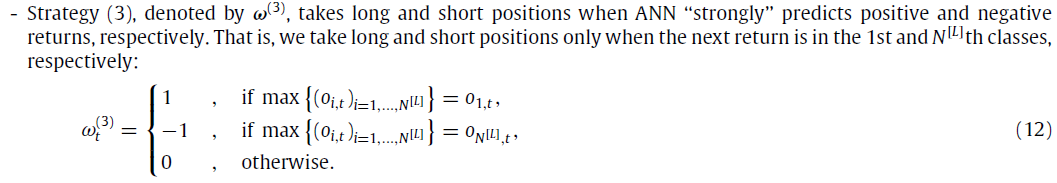

In [93]:
w = pd.Series(np.where(df_backtest['prediction']==0, 1, 0))
w = pd.Series(np.where(df_backtest['prediction']==3, -1, w))
df_backtest['w'] = w
df_backtest['w']

0        0
1        0
2        0
3        0
4        0
        ..
33925    1
33926    1
33927    1
33928    1
33929    1
Name: w, Length: 33930, dtype: int32

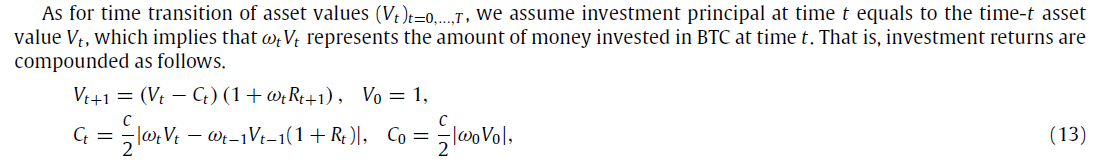

In [94]:
#primeiro teste com c=0
df_backtest['prev_w'] = df_backtest['w'].shift()

In [95]:
df_backtest['prev_w']

0        NaN
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
33925   -1.0
33926    1.0
33927    1.0
33928    1.0
33929    1.0
Name: prev_w, Length: 33930, dtype: float64

In [96]:
V = [1]
for idx,row in df_backtest.iterrows():
    if idx>0:
        V.append(V[-1]*(1+row['prev_w']*row['return']))


In [97]:
V[-1]

1.1743883736956915

In [98]:
df_backtest['close']

0        27896.93
1        27931.04
2        27956.52
3        27930.13
4        27914.64
           ...   
33925    70426.00
33926    70161.09
33927    69871.99
33928    69880.01
33929    69860.00
Name: close, Length: 33930, dtype: float64